In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import joblib as jb
from nltk.tokenize import word_tokenize
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\AD\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

## **TESTING**


In [19]:
tokenizer = AutoTokenizer.from_pretrained('tabularisai/multilingual-sentiment-analysis')
model = AutoModelForSequenceClassification.from_pretrained('tabularisai/multilingual-sentiment-analysis')

In [20]:
def map_to_binary_label(predicted_id):
    if predicted_id <= 2:
        return "NEGATIVE"
    elif predicted_id == 3:
        return "NEUTRAL"
    else: 
        return "POSITIVE"


In [21]:
token = tokenizer.tokenize("I need a hug!") 
tokens = tokenizer.convert_tokens_to_ids(token)
tokens = torch.tensor(tokens).unsqueeze(0) 
output = model(tokens) 
predicted_id = torch.argmax(output.logits, dim=1).item()
predicted_label = map_to_binary_label(predicted_id)
print(predicted_label)


NEUTRAL


## **PREPARE DATA**


In [22]:
df = pd.read_csv(r"C:\Users\AD\Desktop\Data projects\python\Decision-making-system\Data\review.csv")

In [23]:
df_review = df['Review']
df_review.head()
df_review = pd.DataFrame(df_review)
df_review

,Review
0,The battery drains faster than expected. Not h...
1,The illustrations in this book are stunning an...
2,The smartwatch syncs seamlessly with my phone....
3,This poetry collection is beautifully written ...
4,This laptop boots up incredibly fast and is pe...
...,...
195,The plot starts strong but fizzles out midway....
196,"The scarf is nice, but the stitching could be ..."
197,The jacket doesn’t provide enough warmth in co...
198,"The design looks nice, but the quality isn’t g..."


In [24]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  200 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


In [25]:
def expand_contractions(text: str) -> str:
    contractions = {
        "don't": 'do not', "can't": 'cannot', "won't": 'will not', "isn't": 'is not',
        "aren't": 'are not', "wasn't": 'was not', "weren't": 'were not', "hasn't": 'has not',
        "haven't": 'have not', "hadn't": 'had not', "doesn't": 'does not', "didn't": 'did not',
        "shouldn't": 'should not', "couldn't": 'could not', "wouldn't": 'would not', "mightn't": 'might not',
        "mustn't": 'must not', "needn't": 'need not'
    }
    
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text


In [26]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NEGATIVE_WORDS = set(opinion_lexicon.negative())
POSITIVE_WORDS = set(opinion_lexicon.positive())


<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
C:\Users\AD\AppData\Local\Temp\ipykernel_2600\2183955636.py:1: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')


In [27]:
def preprocess_sentiment_text(review):
    review = str(review).lower()
    review = expand_contractions(review)
    review = REPLACE_BY_SPACE_RE.sub(' ', review)
    review = BAD_SYMBOLS_RE.sub('', review)
    review = re.sub(r'https*\S+', ' ', review)  # Remove URLs
    review = re.sub(r'[@#]\S+', ' ', review)    # Remove mentions and hashtags
    review = re.sub('<.*?>', '', review)        # Remove HTML tags
    tokeninzer = word_tokenize(review)
    stop_words = set(stopwords.words('english')) - NEGATIVE_WORDS - POSITIVE_WORDS 
    tokens = [token for token in tokeninzer if token not in stop_words]
    tagged_tokens = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    processed_tokens = []
    for word, tag in tagged_tokens:
        if tag.startswith('JJ'): 
            pos = 'a'
        elif tag.startswith('VB'):  
            pos = 'v'
        elif tag.startswith('NN'):  
            pos = 'n'
        elif tag.startswith('RB'):  
            pos = 'r'
        else:
            pos = 'n'  
        lemmatized = lemmatizer.lemmatize(word, pos=pos)
        processed_tokens.append(lemmatized)
    final_tokens = [
        word.upper() if (tag in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'VBD', 'VBG', 'RBS') or word in NEGATIVE_WORDS or word in POSITIVE_WORDS) 
        else word
        for word, tag in zip(processed_tokens, [t[1] for t in tagged_tokens])
    ]
    processed_review = ' '.join(final_tokens)
    return processed_review

In [28]:
df_review_clean = df_review.copy()
df_review_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  200 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


In [29]:
df_review_clean['Review'] = df_review_clean['Review'].apply(preprocess_sentiment_text)
df_review_clean


,Review
0,battery DRAIN FASTER expect HAPPY
1,illustration book STUN ADD story
2,smartwatch syncs SEAMLESSLY phone CONVENIENT
3,poetry collection BEAUTIFULLY write EMOTIONAL
4,LAPTOP boot INCREDIBLY FAST PERFECT WORK
...,...
195,PLOT start STRONG fizzle MIDWAY MIXED feeling
196,SCARF NICE stitching could BETTER
197,jacket doesnt provide ENOUGH WARMTH colder wea...
198,design look NICE quality isnt GREAT


In [30]:
def predict_sentiment_and_score(text, model, tokenizer):
    token = tokenizer.tokenize(text)
    tokens = tokenizer.convert_tokens_to_ids(token)
    tokens = torch.tensor(tokens).unsqueeze(0)
    
    output = model(tokens)
    predicted_id = torch.argmax(output.logits, dim=1).item()
    
    predicted_label = map_to_binary_label(predicted_id)
    
    
    return predicted_label

In [31]:
text = preprocess_sentiment_text("winter coat WARM AMAZING")
print(text)

winter coat WARM AMAZING


In [32]:
predicted_label = predict_sentiment_and_score(text, model, tokenizer)
predicted_label

'POSITIVE'

In [33]:
reviews = df_review_clean["Review"].tolist()
reviews

['battery DRAIN FASTER expect HAPPY',
 'illustration book STUN ADD story',
 'smartwatch syncs SEAMLESSLY phone CONVENIENT',
 'poetry collection BEAUTIFULLY write EMOTIONAL',
 'LAPTOP boot INCREDIBLY FAST PERFECT WORK',
 'storage unit STURDY plenty space',
 'EXTERNAL HARD drive COMPACT store lot data',
 'hoodie shrunk DRASTICALLY WASH HAPPY',
 'device overheats OFTEN FRUSTRATE',
 'photography GUIDE PRACTICAL EASY understand',
 'feature DECENT build quality feel CHEAP',
 'battery life MUCH BAD ADVERTISE DISAPPOINTING',
 'bookshelf MODERN design fit book',
 'design SLEEK LACK IMPORTANT feature',
 'GREAT value price SOLID build FAST performance',
 'keyboard feel CHEAP ISNT RESPONSIVE',
 'science book explain CONCEPTS SIMPLE CLEAR way',
 'CHARGE cable MISS box POOR quality control',
 'blazer WELLTAILORED PERFECT FORMAL occasion',
 'curtain COMPLETELY block LIGHT PERFECT SLEEP',
 'jean STYLISH run SMALL expect',
 'SCREEN resolution SHARP VIBRANT',
 'textbook COMPREHENSIVE cover SUBJECT detai

In [34]:
df_result = []
for review in df_review_clean['Review']:
    predicted_label = predict_sentiment_and_score(review, model, tokenizer)
    df_result.append({
        "Review": review,
                "Sentiment": predicted_label
    })
df_result = pd.DataFrame(df_result)
df_result.to_csv("review_result.csv", index=False)


In [35]:
df_result = df_result.rename(columns={"Review": "Processed_Review"})
df_result

,Processed_Review,Sentiment
0,battery DRAIN FASTER expect HAPPY,NEGATIVE
1,illustration book STUN ADD story,POSITIVE
2,smartwatch syncs SEAMLESSLY phone CONVENIENT,POSITIVE
3,poetry collection BEAUTIFULLY write EMOTIONAL,POSITIVE
4,LAPTOP boot INCREDIBLY FAST PERFECT WORK,POSITIVE
...,...,...
195,PLOT start STRONG fizzle MIDWAY MIXED feeling,POSITIVE
196,SCARF NICE stitching could BETTER,NEGATIVE
197,jacket doesnt provide ENOUGH WARMTH colder wea...,NEGATIVE
198,design look NICE quality isnt GREAT,NEGATIVE


In [36]:
df_result.to_csv("Customer_review.csv",index = False)
jb.dump(tokenizer,"tokenizer_sentiment.pkl")
jb.dump(model,"NLP.pkl")

['NLP.pkl']

## **Explore the data** ##

Text(0.5, 1.0, ' Reviews Sentiment Distribution')

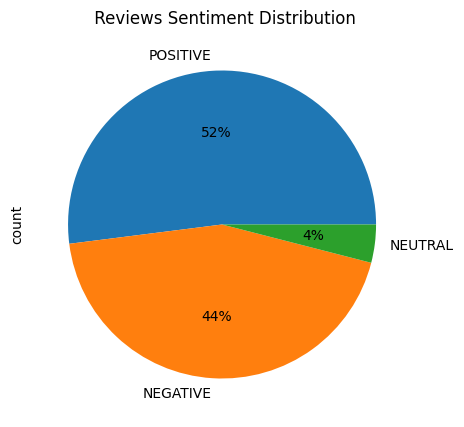

In [37]:
plt.figure(figsize=(15, 5))

df_result['Sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title(f" Reviews Sentiment Distribution")

In [38]:
df_final = pd.concat([df_result, df_review], axis=1)
df_final = df_final[['Review','Processed_Review','Sentiment']]
df_final

,Review,Processed_Review,Sentiment
0,The battery drains faster than expected. Not h...,battery DRAIN FASTER expect HAPPY,NEGATIVE
1,The illustrations in this book are stunning an...,illustration book STUN ADD story,POSITIVE
2,The smartwatch syncs seamlessly with my phone....,smartwatch syncs SEAMLESSLY phone CONVENIENT,POSITIVE
3,This poetry collection is beautifully written ...,poetry collection BEAUTIFULLY write EMOTIONAL,POSITIVE
4,This laptop boots up incredibly fast and is pe...,LAPTOP boot INCREDIBLY FAST PERFECT WORK,POSITIVE
...,...,...,...
195,The plot starts strong but fizzles out midway....,PLOT start STRONG fizzle MIDWAY MIXED feeling,POSITIVE
196,"The scarf is nice, but the stitching could be ...",SCARF NICE stitching could BETTER,NEGATIVE
197,The jacket doesn’t provide enough warmth in co...,jacket doesnt provide ENOUGH WARMTH colder wea...,NEGATIVE
198,"The design looks nice, but the quality isn’t g...",design look NICE quality isnt GREAT,NEGATIVE


In [39]:
df_rating = pd.read_csv(r"C:\Users\AD\Desktop\Data projects\python\Decision-making-system\Data\review_rating.csv")

In [40]:
df_rating = df_rating.rename(columns={"Predicted_Rating":"rating/5"})
df_rating

,review_id,Review,rating/5
0,NaN,The self-help book is very insightful and help...,5.0
1,NaN,"The fan is powerful yet quiet, a perfect combi...",5.0
2,NaN,The winter coat is warm and looks amazing!,4.5
3,NaN,The gaming console has top-notch graphics and ...,4.5
4,NaN,The display started flickering after a week. V...,2.5
...,...,...,...
195,NaN,The science book explains concepts in a simple...,4.5
196,NaN,The toaster makes perfect golden-brown toast e...,5.0
197,NaN,The projector produces a bright and clear imag...,2.0
198,NaN,The bookshelf is decent but came with missing ...,0.5


In [41]:
df_sentiment_report = pd.merge(df_final, df_rating, on='Review', how='inner')
df_sentiment_report = df_sentiment_report[['Review', 'Processed_Review', 'Sentiment', 'rating/5']]
df_sentiment_report.to_csv("sentiment_report.csv", index=False)
df_sentiment_report


,Review,Processed_Review,Sentiment,rating/5
0,The battery drains faster than expected. Not h...,battery DRAIN FASTER expect HAPPY,NEGATIVE,3.5
1,The illustrations in this book are stunning an...,illustration book STUN ADD story,POSITIVE,5.0
2,The smartwatch syncs seamlessly with my phone....,smartwatch syncs SEAMLESSLY phone CONVENIENT,POSITIVE,3.0
3,This poetry collection is beautifully written ...,poetry collection BEAUTIFULLY write EMOTIONAL,POSITIVE,3.0
4,This laptop boots up incredibly fast and is pe...,LAPTOP boot INCREDIBLY FAST PERFECT WORK,POSITIVE,5.0
...,...,...,...,...
194,The plot starts strong but fizzles out midway....,PLOT start STRONG fizzle MIDWAY MIXED feeling,POSITIVE,2.0
195,"The scarf is nice, but the stitching could be ...",SCARF NICE stitching could BETTER,NEGATIVE,4.0
196,The jacket doesn’t provide enough warmth in co...,jacket doesnt provide ENOUGH WARMTH colder wea...,NEGATIVE,4.5
197,"The design looks nice, but the quality isn’t g...",design look NICE quality isnt GREAT,NEGATIVE,5.0


In [42]:
import numpy as np

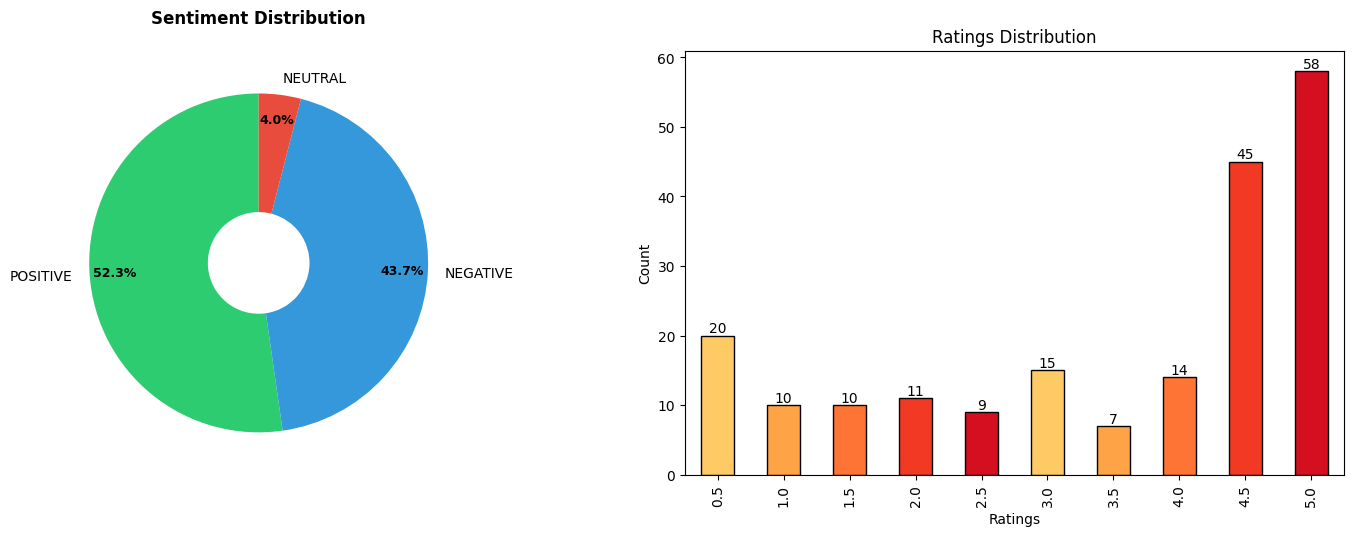

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sentiment_colors = ['#2ecc71', '#3498db', '#e74c3c']
rating_colors = plt.cm.YlOrRd(np.linspace(0.3, 0.8, 5))
sentiment_counts = df_sentiment_report['Sentiment'].value_counts()
patches, texts, autotexts = ax1.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=sentiment_colors,
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'width': 0.7}  
)
plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=10)
ax1.set_title("Sentiment Distribution", pad=20, fontsize=12, fontweight='bold')
ax = plt.gca()
bars = df_sentiment_report['rating/5'].value_counts().sort_index().plot(
    kind='bar',
    color=rating_colors,
    edgecolor='black',
    ax=ax
)
for rect in bars.patches:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2.,
        height,
        f'{int(height):,}',
        ha='center',
        va='bottom'
    )

plt.title('Ratings Distribution')
plt.xlabel('Ratings')
plt.ylabel('Count')

plt.tight_layout(pad=3.0)
plt.show() 

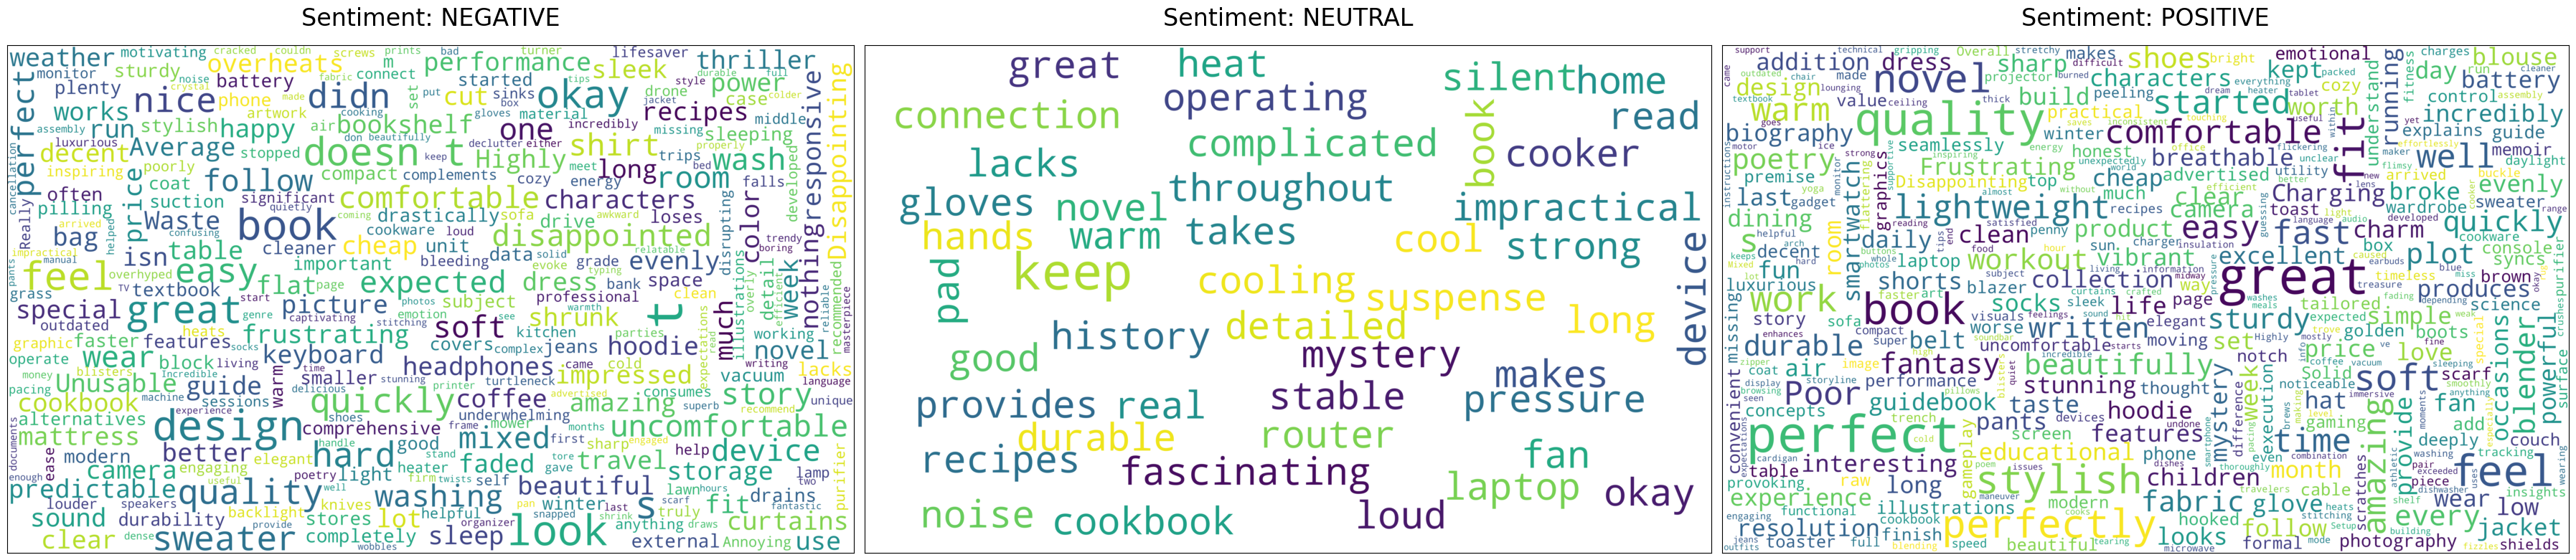

In [44]:

stopwords = set(STOPWORDS)
unique_sentiments = sorted(df_sentiment_report['Sentiment'].unique())
plt.figure(figsize=(36, 12))
for index, sentiment in enumerate(unique_sentiments, start=1):
    plt.subplot(1, 3, index)
    df_filtered = df_sentiment_report[df_sentiment_report['Sentiment'] == sentiment]
    data = " ".join(df_filtered['Review'].astype(str))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=60,
        scale=6,
        width=1000,
        height=600).generate(data)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Sentiment: {sentiment.upper()}", fontsize=24, pad=20)

plt.tight_layout()
plt.show()